# Лабораторная работы №3 "Сезонные модели"
## Импортирование библиотек

In [153]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.gridspec import GridSpec

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import statsmodels
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from scipy import stats
from tabulate import tabulate
from itertools import product

import warnings
warnings.filterwarnings("ignore")

## Загрузка входных данных

In [154]:
dist = pd.read_csv('data/season.csv')
season = dist["liquor"].dropna()
season

0       480
1       467
2       514
3       505
4       534
       ... 
331    1776
332    1743
333    1728
334    1769
335    2431
Name: liquor, Length: 336, dtype: int64

## График процесса, его АКФ и ЧАКФ

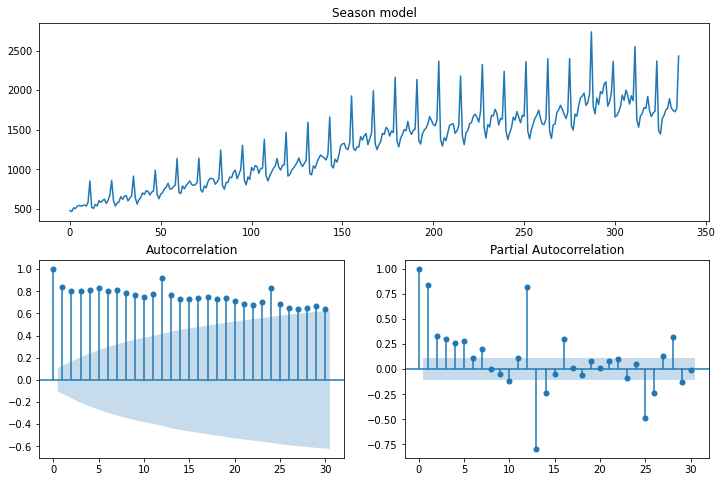

In [155]:
lagCount = 30
fig = plt.figure(figsize=(12, 8))

gs = GridSpec(2, 2, wspace=0.2, hspace=0.2)

ax1 = fig.add_subplot(gs[0, :])
ax1.set_title('Season model')
ax1.plot(season)

ax2 = fig.add_subplot(gs[1, :-1])
_ = plot_acf(season, ax = ax2, lags = lagCount)

ax3 = fig.add_subplot(gs[1:, -1])
_ = plot_pacf(season, ax = ax3, lags = lagCount)

plt.show()

## Удаление тренда

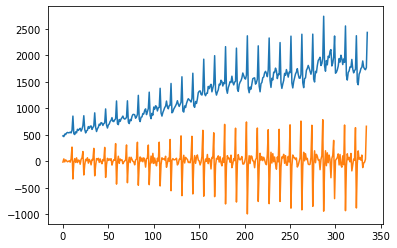

In [156]:
diff = list()
for i in range(1, len(season)):
	value = season[i] - season[i - 1]
	diff.append(value)
plt.plot(season, label='season')
plt.plot(diff, label='not trend')
plt.show()

## График процесса, его АКФ и ЧАКФ без тренда

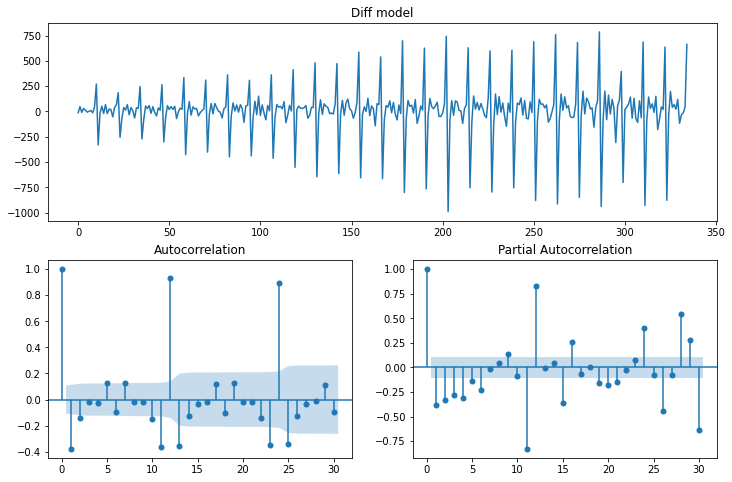

In [190]:
lagCount = 30
fig = plt.figure(figsize=(12, 8))

gs = GridSpec(2, 2, wspace=0.2, hspace=0.2)

ax1 = fig.add_subplot(gs[0, :])
ax1.set_title('Diff model')
ax1.plot(diff)

ax2 = fig.add_subplot(gs[1, :-1])
_ = plot_acf(diff, ax = ax2, lags = lagCount)

ax3 = fig.add_subplot(gs[1:, -1])
_ = plot_pacf(diff, ax = ax3, lags = lagCount)

plt.show()

### Проанализируем графики АКФ и ЧАКФ, для определения максимальных порядков модели

### Проведём обучение для всех моделей, порядок которых ниже максимального порядка модели.

In [158]:
pSeason = [0, 1, 2]
qSeason = [0, 1, 2]
pOrder  = [0, 1, 2]
qOrder  = [0, 1, 2]
models = {}

for i in pOrder:
    for j in qOrder:
        for k in pSeason:
            for l in qSeason:
                if ((i, j ,k, l) == (0, 0, 0, 0)):
                    continue
                arimax = SARIMAX(np.array(diff), order=(i, 0, j), seasonal_order=(k, 0, l, 12), initialization='approximate_diffuse').fit()
                pVal = arimax.pvalues
                if all(i <= 0.05 for i in pVal):
                    models[i, j, k, l] = arimax

### Количество моделей, имеющих значимые коэффициенты, то есть pVal < 0.05

In [159]:
print(f'Количество моделей: {len(models.keys())}')

Количество моделей: 45


### Разделение данных на обучающую и тестовую выборки

In [160]:
split_diff = int(len(diff) * 0.7)
diff_train, diff_test = diff[:split_diff], diff[split_diff:]
diff_train = np.array(diff_train)
diff_test = np.array(diff_test)

## Вычисление стандартной ошибки для моделей

In [161]:
def standard_error(y, y_1, order):
    return np.sqrt(np.sum(np.square((y_1 - y))) / (len(y) - order))

In [162]:
def standard_error_model(train, test, model):
    k = max(model.model_orders['ar'], model.model_orders['ma'])
    standard_error_train = standard_error(train, model.predict(0, len(train) - 1), k)
    standard_error_test = standard_error(test, model.forecast(len(test)), k)
    return standard_error_train, standard_error_test

In [163]:
m = {}

dict_se_train = {}
dict_se_test = {}
dict_aic = {}
dict_bic = {}
for name, model in models.items():
    tmp_dict = {}
    se_train, se_test = standard_error_model(diff_train, diff_test, model)

    dict_se_train[name] = se_train
    dict_se_test[name] = se_test
    dict_aic[name] = model.aic
    dict_bic[name] = model.bic

    tmp_dict['SE Train'] = se_train
    tmp_dict['SE Test'] = se_test
    tmp_dict['AIC'] = model.aic
    tmp_dict['BIC'] = model.bic
    m[name] = tmp_dict

data = {
    'Model': list(m.keys()),
    'SE Train': list(dict_se_train.values()),
    'SE Test': list(dict_se_test.values()),
    'AIC': list(dict_aic.values()),
    'BIC': list(dict_bic.values())
}

df = pd.DataFrame.from_dict(data)
# df.set_index('Model')
dfAIC = df.sort_values("AIC")

## Таблица результатов моделей, отсортированных по критерию Акаике

In [164]:
dfAIC.head(10)

,Model,SE Train,SE Test,AIC,BIC
32,"(2, 0, 1, 1)",47.705474,436.495831,3638.247790,3657.318442
9,"(0, 1, 1, 1)",50.453371,432.435336,3662.717513,3677.974035
15,"(0, 2, 1, 1)",50.299465,435.192358,3664.312689,3683.383342
27,"(1, 2, 1, 1)",51.882841,434.587156,3674.661382,3697.546165
20,"(1, 0, 1, 1)",51.121587,432.790308,3689.894332,3705.150854
36,"(2, 1, 1, 1)",56.159222,433.520312,3702.422476,3725.307259
34,"(2, 0, 2, 1)",47.608632,441.200429,3703.215793,3726.100576
33,"(2, 0, 2, 0)",48.235782,446.801348,3704.240094,3723.310746
16,"(0, 2, 2, 0)",50.273502,445.606584,3717.560106,3736.630759
35,"(2, 1, 1, 0)",50.152628,443.093874,3717.836857,3736.907509


## Анализ остатков моделей
### Отсортировав все модели по критерию акаике, выберем первые 5

### Построим их АКФ и ЧАКФ

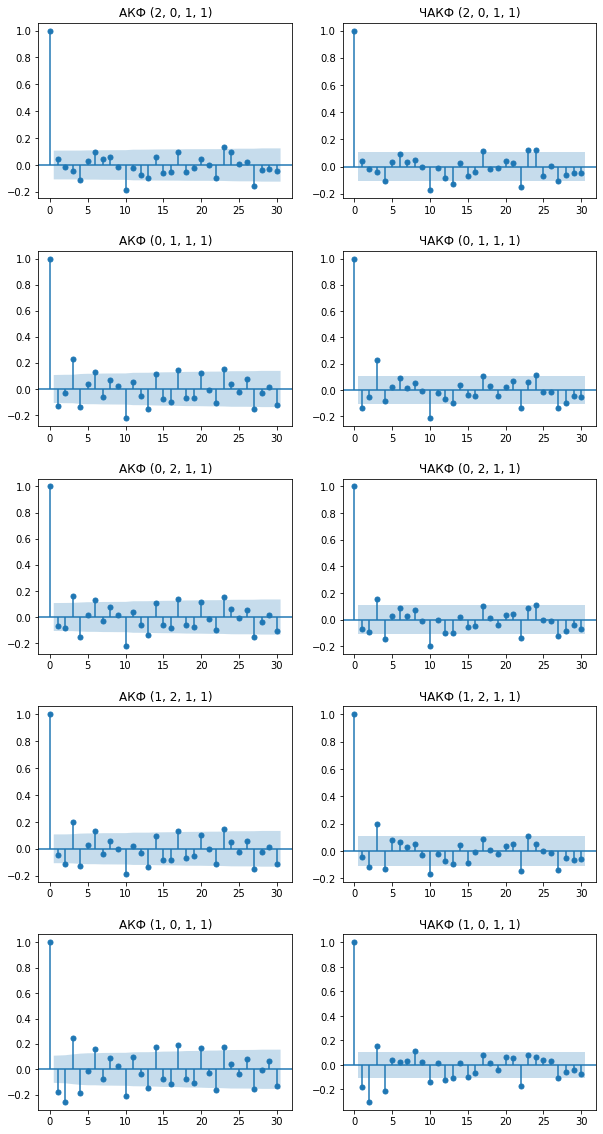

In [194]:
lagCount = 30
top_model = 5
width = 2
height = 4
fig = plt.figure( figsize=( width * len(dfAIC.head(top_model)['Model']), height * len(dfAIC.head(top_model)['Model'] ) ) )

for idx, elem in enumerate(dfAIC.head(top_model)['Model']):
    gs = GridSpec(len(dfAIC.head(top_model)['Model']), 2, wspace = 0.2, hspace = 0.3)

    m = models[elem]
    ax1 = fig.add_subplot(gs[idx, 0])
    ax2 = fig.add_subplot(gs[idx, 1])
    _ = plot_acf(m.resid, ax = ax1, lags = lagCount, title=f'АКФ {elem}')
    _ = plot_pacf(m.resid, ax = ax2, lags = lagCount, title=f'ЧАКФ {elem}')  
plt.show()
